# Linguistics Project

#### Goal: Predict Emotions from recorded speech

In [220]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import wave
import sys
import os
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import glob
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize 

In [221]:
data_dir = '../data/Audio_Speech_Actors_01-24/Actor_07'
data_file = '03-01-01-01-01-01-07.wav'

data_path = os.path.join(data_dir, data_file)

In [222]:
def list_all_files(path='../data/Audio_Speech_Actors_01-24/'):
    relevant_files_regex = 'Actor_*/03-01-*.wav'
    relevant_files_list = glob.glob(path + relevant_files_regex)
    return relevant_files_list

In [223]:
#STFT https://towardsdatascience.com/audio-processing-in-tensorflow-208f1a4103aa
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    # Take segments from the signal
    nperseg = int(round(window_size * sample_rate / 1e3))
    # provides a 'smoother' spec compared to with 0 overlap
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    # Transpose spec-matrix into a 32-float array
    spectrogram = spec.astype(np.float32)
    log_spectrogram = np.log10(spectrogram + eps)
    return freqs, times, log_spectrogram

Length in Nr. of Samples: 42496


Text(0.5,0,'Seconds')

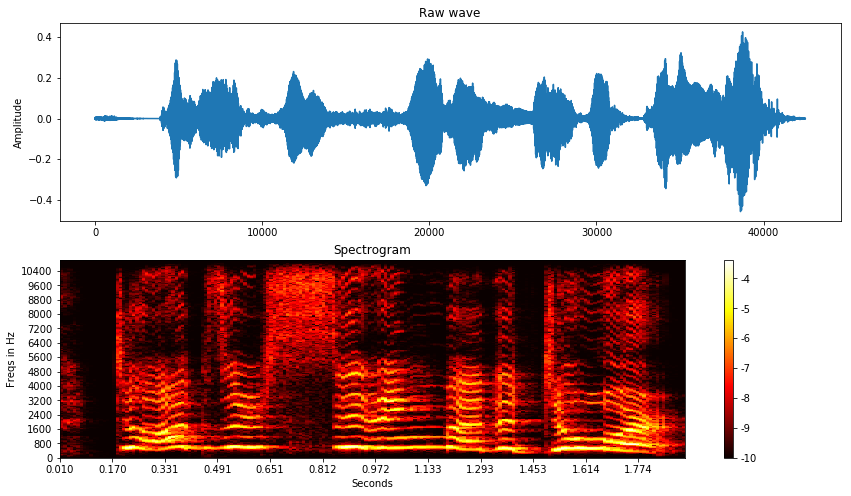

In [224]:
# Draw and plot random sample + its spectrogram

#trim all noise below 30Db at the beginning and end of time-axes
#trim one specific file

relevant_files_list = list_all_files()

raw_samples, sample_rate = librosa.load(random.choice(relevant_files_list))
samples, index = librosa.effects.trim(raw_samples, top_db=35)

freqs, times, spectrogram = log_specgram(samples, sample_rate)

print('Length in Nr. of Samples: {}'.format(len(samples)))

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave')
ax1.set_ylabel('Amplitude')
ax1.plot(samples)

ax2 = fig.add_subplot(212)
s = ax2.imshow(spectrogram, aspect='auto', cmap='hot', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
plt.colorbar(s, ax=ax2, format='%+02.0f')
ax2.set_title('Spectrogram')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

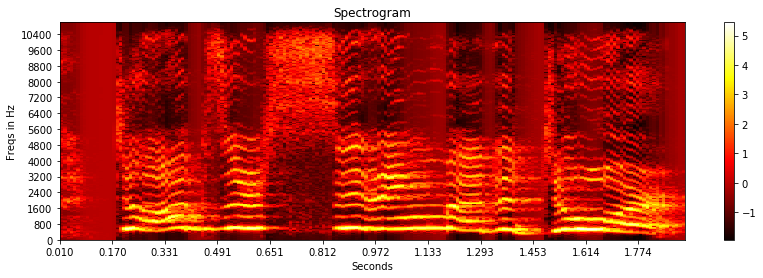

In [225]:
# mean vector
# ToDo: Axis 0 or Axis 1?

#Axis 0
feature_mean = np.mean(spectrogram, axis=0)
centered_spectrogram = spectrogram - feature_mean
#Axis 1
#feature_mean = np.mean(spectrogram, axis=1)
#centered_spectrogram = (spectrogram.T - feature_mean).T
 
plt.figure(figsize=(14,4))
s= plt.imshow(centered_spectrogram, aspect='auto', cmap='hot', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.colorbar(s)
plt.title('Spectrogram')
plt.ylabel('Freqs in Hz')
plt.xlabel('Seconds')
plt.show()

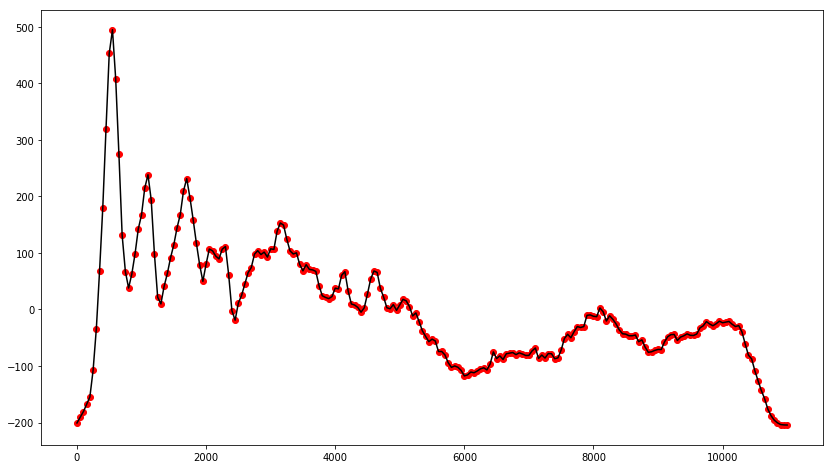

In [226]:
sum_frequ = np.sum(centered_spectrogram, axis=1)
uncentered_sum_frequ = np.sum(spectrogram, axis=1)

plt.figure(figsize=(14,8))
plt.scatter(freqs, sum_frequ, color='red')
plt.plot(freqs, sum_frequ, color='black')
plt.show()


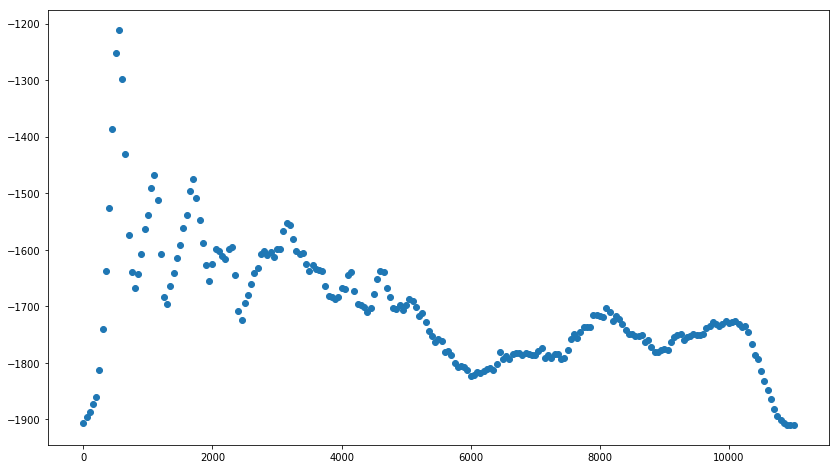

In [227]:
plt.figure(figsize=(14,8))
plt.scatter(freqs, uncentered_sum_frequ)
plt.show()

In [228]:
#center entire data set

def process_data_set():
    list_sum_frequs = []
    list_labels = []
    for i, file in enumerate(relevant_files_list, 1):
        emotion_number = int(file.split('/')[-1].split('-')[2].lstrip('0'))
        list_labels.append(emotion_number)
        
        raw_samples, sample_rate = librosa.load(file)
        samples, index = librosa.effects.trim(raw_samples, top_db=35)
        freqs, times, spectrogram = log_specgram(samples, sample_rate)
        #Axis 0
        feature_mean = np.mean(spectrogram, axis=0)
        centered_spectrogram = spectrogram - feature_mean
        
        sum_frequ = np.sum(centered_spectrogram, axis=1)
        list_sum_frequs.append(list(sum_frequ))
        
        sys.stdout.write('\riteration {}'.format(i))
        sys.stdout.flush()
    return np.asarray(list_sum_frequs), np.asarray(list_labels), np.mean(list_sum_frequs, axis=0)
        
        
        

In [229]:
#data, labels, mean = process_data_set()

#np.savez('./sum_frequ_data', data=data, labels=labels)
#np.save('./sum_frequ_mean', mean)

# Normalize data

In [230]:
try:
    dataset = np.load('./sum_frequ_data.npz')
    data_mean = np.load('./sum_frequ_mean.npy')
except:
    print('File with num_frequ_mean not found')

entire_dataset_train_x = dataset['data']
c_entire_dataset_train_x = entire_dataset_train_x - data_mean
normalized_data = normalize(c_entire_dataset_train_x, axis=0)


entire_labelset_train_y = dataset['labels']

print(train_x.shape, train_y.shape, data_mean.shape)

(1200, 221) (1200,) (221,)


# *Principle Component Analysis*
**==> reduce dimensions from 221 to fewer, meaningful dimensions
The principal components are the largest Eigenvectors of the covariance matrix of the dataset.**

In [353]:
pca = PCA(n_components=140)
pca.fit(normalized_data)
reduced_train_x = pca.transform(normalized_data)
print(reduced_train_x.shape)
print(reduced_train_x)

(1440, 140)
[[-1.22822672e-02 -7.86545947e-02 -4.87872772e-02 ... -3.73642892e-03
  -6.71514485e-04 -8.48341093e-04]
 [-2.09147975e-01 -1.87752489e-02 -1.24148235e-01 ... -1.16244424e-03
  -4.69761901e-03 -4.70860075e-04]
 [ 4.24627453e-01 -8.33817422e-02 -1.16872385e-01 ...  5.13376528e-03
   2.86548719e-04 -6.22648746e-03]
 ...
 [-3.21249425e-01 -7.50425039e-03 -6.21571206e-03 ... -1.01411424e-03
  -1.23942300e-04 -6.35767123e-04]
 [-3.15580517e-01 -1.88675784e-02  1.45413196e-02 ...  6.72213093e-04
  -9.06003930e-04  9.53004987e-04]
 [-2.17830539e-01 -6.36254810e-03 -2.89110103e-05 ... -7.42997276e-04
   2.09888816e-03  1.82039058e-03]]


In [354]:
size_training_set = 1200

train_x, test_x = np.split(reduced_train_x, [size_training_set])
train_y, test_y = np.split(entire_labelset_train_y, [size_training_set])

## *SVM*

In [355]:
################## SVM ##################

parameters = {'C' : [0.1, 1., 10.],
              'gamma' : [0.1, 'auto']}

svm_estimator = svm.SVC()
#Grid Search, clf = Classifier
clf = GridSearchCV(svm_estimator, parameters)
clf.fit(train_x, train_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1.0, 10.0], 'gamma': [0.1, 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# *Gridsearch best parameters and best scores*

In [356]:
print('Best Score: {}'.format(clf.best_score_))
print('Best Parameters: {}'.format(clf.best_params_))
estimator = clf.best_estimator_
print('Best estimator: {}'.format(estimator))

Best Score: 0.30333333333333334
Best Parameters: {'C': 10.0, 'gamma': 0.1}
Best estimator: SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


# Evaluate the Model
select one emotion and let it predict by SVM 

In [357]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
label_mapping = {1 : 'neutral',
                2 : 'calm',
                3 : 'happy',
                4 : 'sad',
                5 : 'angry',
                6 : 'fearful', 
                7 : 'disgust',
                8 : 'surprised'}

In [358]:
index = random.randint(0, 240)
print('Das {}. Sample'.format(index))
test_sample = np.expand_dims(test_x[index],0)
test_label = test_y[index]
print('Mit Label {} ({}):'.format(test_label, label_mapping[test_label]))
print(test_sample)
prediction = clf.predict(test_sample)[0]
print('The prediction is: {} ({})'.format(prediction, label_mapping[prediction]))

Das 131. Sample
Mit Label 3 (happy):
[[ 2.0465702e-02  1.0030529e-01 -6.9955051e-02 -4.1458547e-02
  -3.2454804e-02  3.9995965e-02 -6.4344957e-02 -2.3259148e-02
  -1.9945318e-02 -2.9692072e-02 -5.2198707e-03  1.8576099e-02
   2.8612681e-02 -2.5281408e-03 -3.5287719e-02  3.1256307e-02
   1.0201011e-02  3.1380568e-02 -2.3759517e-03  3.1702127e-04
  -7.3636300e-03  2.0551460e-02 -7.7275763e-04 -5.4861950e-03
   9.3094604e-03  1.1063803e-02 -8.2436728e-04 -9.0247421e-03
   1.9220237e-02  1.7422287e-02 -3.2049622e-03  1.2821083e-02
   3.1069003e-03  1.6245075e-03 -6.2843719e-03  2.2641520e-03
   4.4003385e-03 -1.3506503e-02  5.3797066e-03  4.3109278e-03
   1.3059800e-02  5.6129484e-04 -5.8489870e-03 -8.7881275e-03
   4.2861938e-03  2.5962741e-04 -4.3379990e-03 -3.5806501e-03
   1.0972223e-02  4.1936478e-03  4.1630538e-03 -3.1338681e-03
  -4.6860422e-03 -3.7958252e-03 -1.2049478e-03  2.2628331e-03
   3.5090812e-03 -8.8851079e-03 -5.7869982e-03 -3.3634498e-03
  -2.0648288e-03  2.4099855e-03 -

# *Accuracy*

In [359]:
entire_train_predictions = clf.predict(train_x)
print('The Accuracy of the training set is {}'.format(np.mean(entire_train_predictions==train_y)))
entire_test_predictions = clf.predict(test_x)
print('The Accuracy of the test training set is {}'.format(np.mean(entire_test_predictions==test_y)))


The Accuracy of the training set is 0.4
The Accuracy of the test training set is 0.38333333333333336


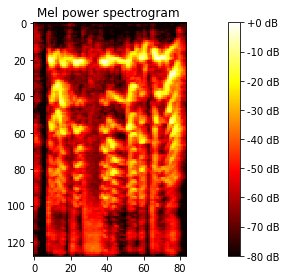

In [238]:
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
#librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.imshow(log_S, cmap='hot')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

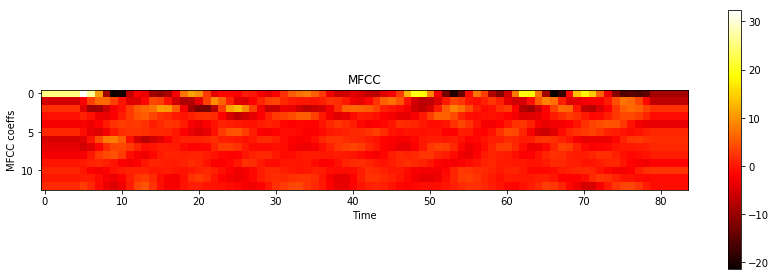

In [239]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
#librosa.display.specshow(delta2_mfcc)
plt.imshow(delta2_mfcc, cmap='hot')
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()